## Домашняя работа №3

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

2. Подберите параметры модели SARIMAX для этого ряда.

3. Сделайте вывод о том, как изменилась модель по сравнению с недельной.

4. Постройте ACF, PACF и модель ARIMA для BRENT (недельный ресемплинг)

5. Оцените результат моделирования

6. Сделайте предположение о моделях, которые лучше работают с техниками регрессии на основе ARIMA.

#### 1. Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.arima_model import ARIMA
from random import random

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
Path_Energy = 'my_PJME_MW.csv'
data_energy_D = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data_energy_D.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [3]:
data_energy_W = data_energy_D.resample('W').mean()
data_energy = data_energy_D.resample('M').mean()
data_energy.drop(columns=['dayofyear','weekofyear','dayofweek', 'hour', 'is_holiday', 'is_prev_holiday', 'is_next_holiday'],inplace=True)

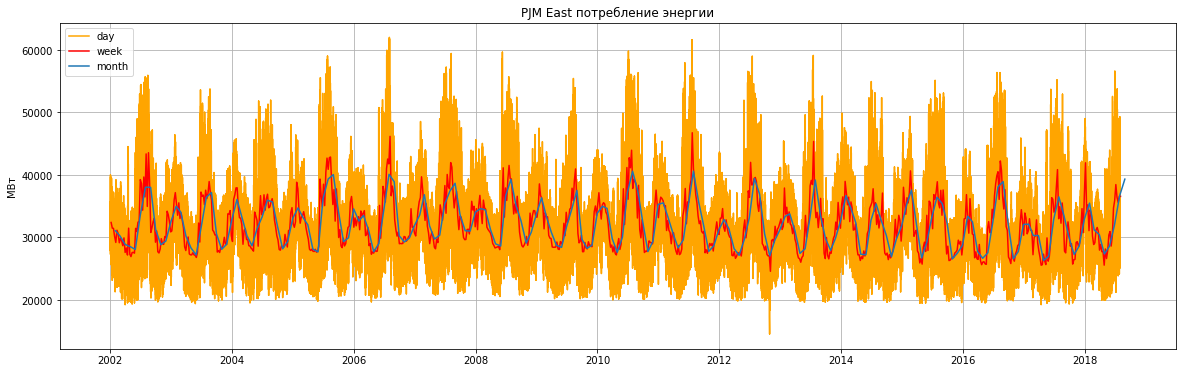

In [4]:
plt.figure(figsize =(20,6))
plt.plot(data_energy_D.index, data_energy_D['PJME_MW'], 'orange', label ='day')
plt.plot(data_energy_W.index, data_energy_W['PJME_MW'], 'r', label ='week')
plt.plot(data_energy['PJME_MW'], label ='month')

plt.ylabel('МВт')
plt.title('PJM East потребление энергии')
plt.legend()
plt.grid()
plt.show();

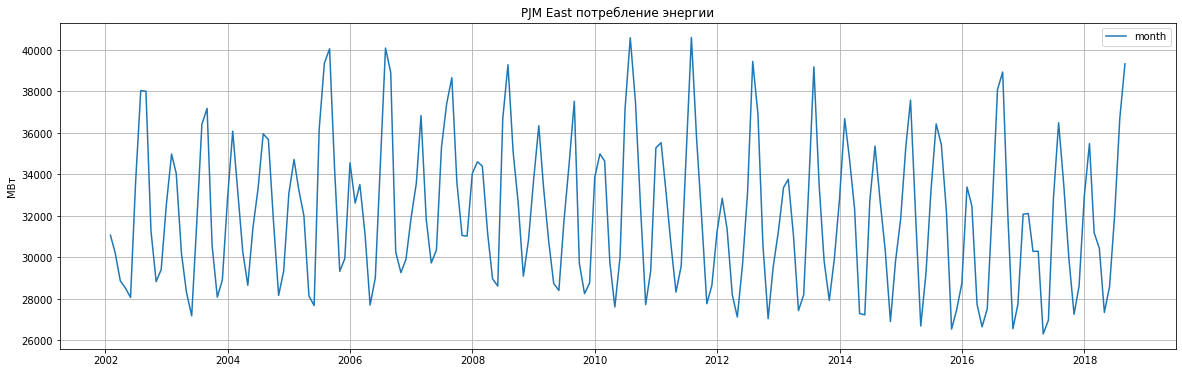

In [5]:
plt.figure(figsize =(20,6))
plt.plot(data_energy['PJME_MW'], label ='month')

plt.ylabel('МВт')
plt.title('PJM East потребление энергии')
plt.legend()
plt.grid()
plt.show();

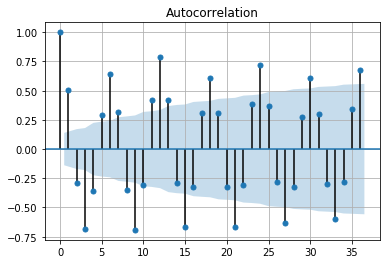

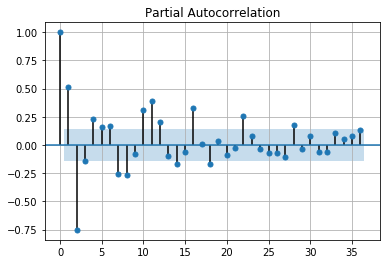

In [6]:
sm.graphics.tsa.plot_acf(data_energy['PJME_MW'].values, lags=36)
plt.grid()
sm.graphics.tsa.plot_pacf(data_energy['PJME_MW'].values, lags=36)
plt.grid()
plt.show();

#### 2. Подберите параметры модели SARIMAX для этого ряда.

In [7]:
%%time

# Определим p, d и q 
q = 6
p = 1
d = 1
pdq = [p, d, q]

# определим комбинации сезонных параметров p, q и q, 
# будем работать с месячными данными, тогда сезонность это 12 месяцев
qs = 2
ps = 1
ds = 1
seasonal_pdq = [ps, ds, qs , 12] 

# в качестве тестовых данных используем 12 последних месяца ряда
mod = sm.tsa.statespace.SARIMAX(data_energy['PJME_MW'].values[:-12],
                                order=pdq,
                                seasonal_order=seasonal_pdq,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print('SARIMAX{}x{} - AIC:{}'.format(pdq, seasonal_pdq, results.aic))

SARIMAX[1, 1, 6]x[1, 1, 2, 12] - AIC:2543.3351960101745
Wall time: 20.2 s


In [8]:
print(results.summary().tables[0],results.summary().tables[1])

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  188
Model:             SARIMAX(1, 1, 6)x(1, 1, [1, 2], 12)   Log Likelihood               -1260.668
Date:                                 Sat, 18 Apr 2020   AIC                           2543.335
Time:                                         22:24:29   BIC                           2576.003
Sample:                                              0   HQIC                          2556.610
                                                 - 188                                         
Covariance Type:                                   opg                                         
=============================================================================================== ==============================================================================
                 coef    std err          z      P>|z|   

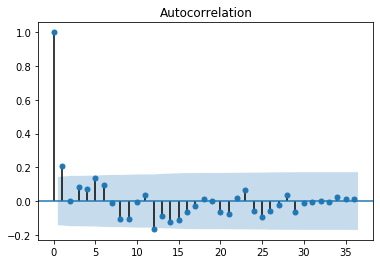

In [9]:
sm.graphics.tsa.plot_acf(results.resid, lags=36)
plt.show()

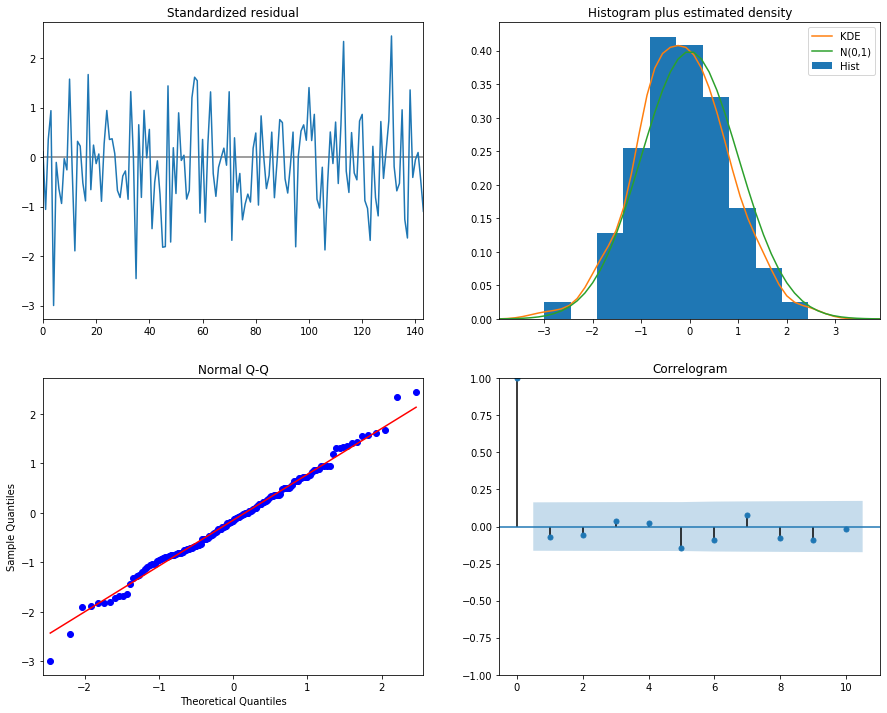

In [10]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

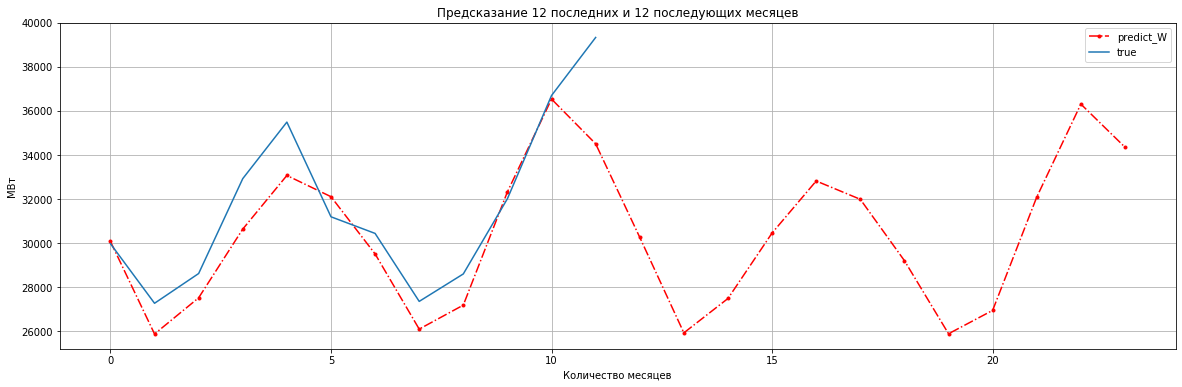

In [11]:
pred_W = results.forecast(24)    #делаем предсказание на 3 точки от текущего конца ряда

# отобразим истинный значения 
plt.figure(figsize =(20,6))
plt.plot(pred_W, '-..r', label='predict_W')
plt.plot(data_energy['PJME_MW'].values[-12:], label='true')
plt.title('Предсказание 12 последних и 12 последующих месяцев')
plt.xlabel('Количество месяцев')
plt.ylabel('МВт')
plt.legend()
plt.grid()
plt.show();

#### 3. Сделайте вывод о том, как изменилась модель по сравнению с недельной.

В сравнение с недельной моделью сезонность стала более выраженной и месячная модель стала лучше пронозировать. Полученные графики позволяют сделать вывод о том, что выбранная модель (удовлетворительно) подходит для анализа и прогнозирования данных временных рядов.

#### 4. Постройте ACF, PACF и модель ARIMA для BRENT (недельный ресемплинг).

In [12]:
Path_Brent = 'my_BRENT2019.csv'
data_brent_D = pd.read_csv(Path_Brent, index_col=[0], parse_dates=[0])

data_brent_D.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [13]:
data_brent_W = data_brent_D.resample('W').mean()
data_brent = data_brent_D.resample('M').mean()
data_brent.drop(columns=['dayofyear', 'weekofyear', 'dayofweek', 'is_holiday', 'is_prev_holiday', 'is_next_holiday'], inplace=True)

In [14]:
data_brent['Значение'] = data_brent['Значение'].astype('int')
data_brent.drop(columns=['year', 'month', 'dayofmonth', 'quarter'], inplace=True)
data_brent.head()

,Значение
Дата,
2010-09-30,78
2010-10-31,83
2010-11-30,86
2010-12-31,92
2011-01-31,97


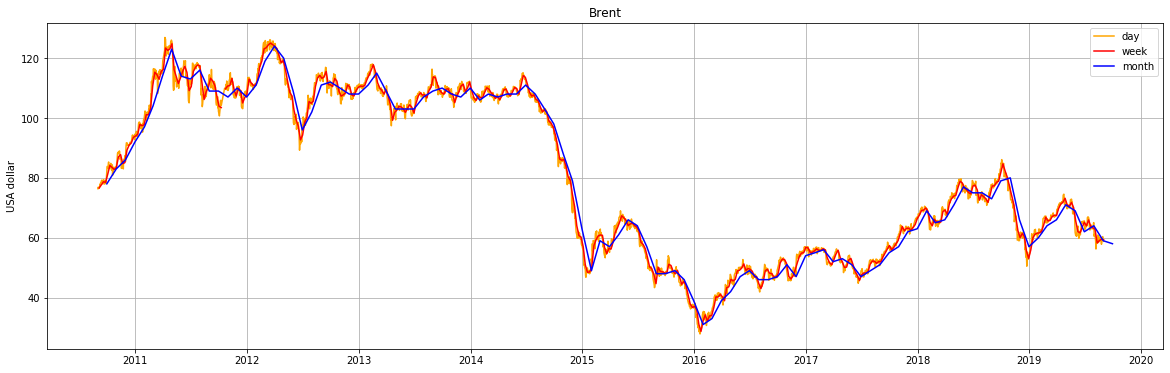

In [15]:
plt.figure(figsize =(20,6))
plt.plot(data_brent_D.index, data_brent_D['Значение'], 'orange', label ='day')
plt.plot(data_brent_W.index, data_brent_W['Значение'], 'r', label ='week')
plt.plot(data_brent['Значение'], 'b', label ='month')

plt.ylabel('USA dollar')
plt.title('Brent')
plt.legend()
plt.grid()
plt.show();

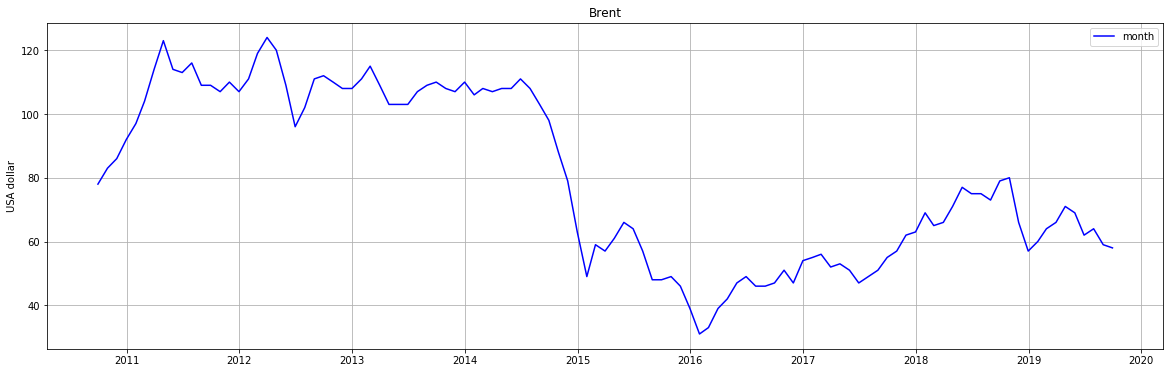

In [16]:
plt.figure(figsize =(20,6))
plt.plot(data_brent['Значение'], 'b', label ='month')

plt.ylabel('USA dollar')
plt.title('Brent')
plt.legend()
plt.grid()
plt.show();

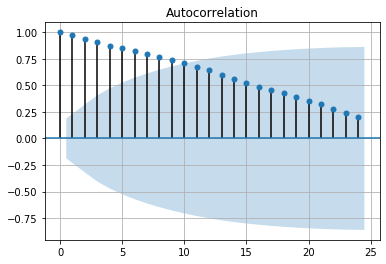

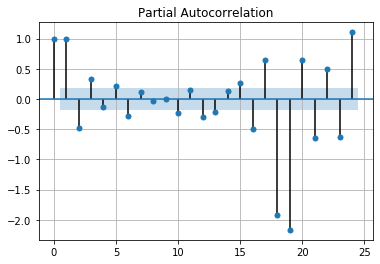

In [17]:
sm.graphics.tsa.plot_acf(data_brent['Значение'].values, lags=24)
plt.grid()
sm.graphics.tsa.plot_pacf(data_brent['Значение'].values, lags=24)
plt.grid()
plt.show();

Запустим модель без сезонного анализа (ARIMA)

In [18]:
# Определим p, d и q 
q = 1
p = 2
d = 1
pdq = [p, d, q]


warnings.filterwarnings("ignore") # отключает предупреждения

modb = sm.tsa.statespace.SARIMAX(data_brent['Значение'].values[:-10],
                               order=pdq,seasonal_order=[0,0,0,0], trend='ct',
                               enforce_stationarity=False,
                               enforce_invertibility=False)
resultsb = modb.fit()
print('ARIMA{} - AIC:{}'.format(pdq, resultsb.aic))

print(resultsb.summary().tables[0],resultsb.summary().tables[1])

ARIMA[2, 1, 1] - AIC:594.7728139597912
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   99
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -291.386
Date:                Sat, 18 Apr 2020   AIC                            594.773
Time:                        22:24:32   BIC                            610.159
Sample:                             0   HQIC                           600.992
                                 - 99                                         
Covariance Type:                  opg                                         
============================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    

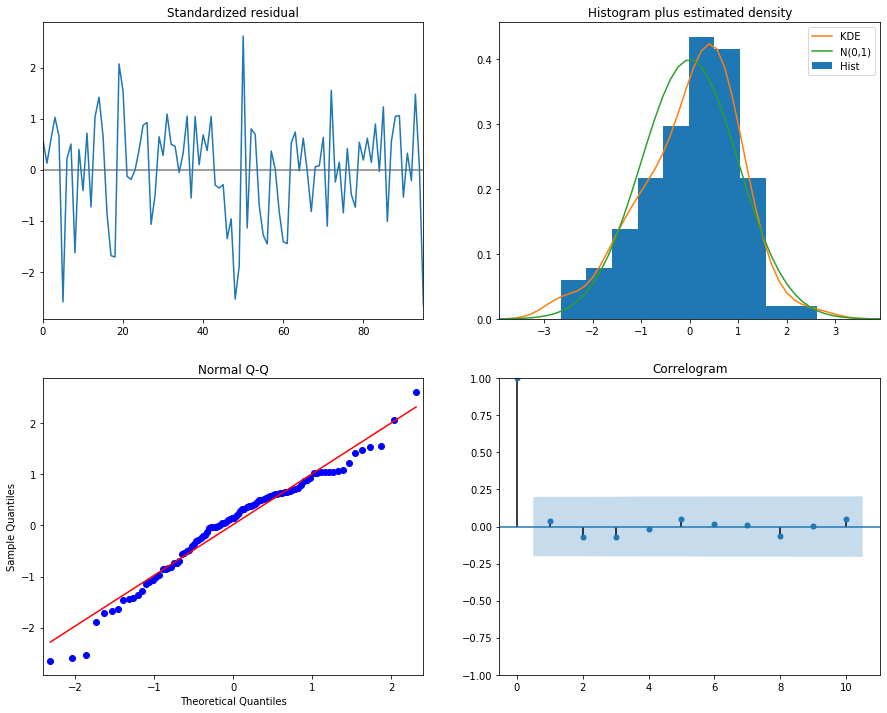

In [19]:
resultsb.plot_diagnostics(figsize=(15, 12))
plt.show()

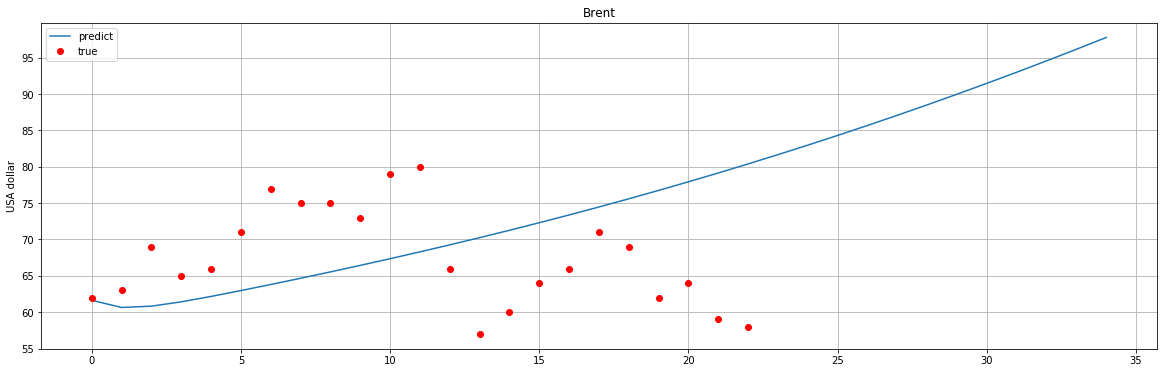

In [20]:
pred_dynamic = resultsb.forecast(35)    #делаем предсказание на 3 точки от текущего конца ряда
plt.figure(figsize =(20,6))
plt.plot(pred_dynamic, label='predict')

#Отобразим истинный значения 
plt.plot(data_brent['Значение'].values[-23:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 12 точек ряда')
 
plt.ylabel('USA dollar')
plt.title('Brent')
plt.legend()
plt.grid()
plt.show()

Для подбора оптимальных значений параметров модели временного ряда ARIMA (p, d, q), используем сеточный поиск

In [21]:
import itertools
# Определим p, d и q в диапазоне 0-3
d = [0,1]
p = [0,1] 
q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [0,0,0,0] # нет сезона

warnings.filterwarnings("ignore") # отключает предупреждения

for param in pdq:
    param_seasonal = seasonal_pdq
    try:
        mod_b = sm.tsa.statespace.SARIMAX(np.log(data_brent['Значение'].values[:-10]),
                                          order=param,seasonal_order=[0,0,0,0],trend='ct',
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)

        results_ = mod_b.fit()
        print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_.aic))
    except:
        continue

ARIMA(0, 0, 0)x[0, 0, 0, 0] - AIC:20.808589766167223
ARIMA(0, 0, 1)x[0, 0, 0, 0] - AIC:-81.36347000533316
ARIMA(0, 0, 2)x[0, 0, 0, 0] - AIC:-139.83647372047434
ARIMA(0, 1, 0)x[0, 0, 0, 0] - AIC:-210.9278670753783
ARIMA(0, 1, 1)x[0, 0, 0, 0] - AIC:-213.64673820172135
ARIMA(0, 1, 2)x[0, 0, 0, 0] - AIC:-208.95937651602594
ARIMA(1, 0, 0)x[0, 0, 0, 0] - AIC:-214.6388136560554
ARIMA(1, 0, 1)x[0, 0, 0, 0] - AIC:-218.43782457465633
ARIMA(1, 0, 2)x[0, 0, 0, 0] - AIC:-213.8318478637146
ARIMA(1, 1, 0)x[0, 0, 0, 0] - AIC:-216.7272700247331
ARIMA(1, 1, 1)x[0, 0, 0, 0] - AIC:-211.79924074511203
ARIMA(1, 1, 2)x[0, 0, 0, 0] - AIC:-206.7345842574317


Поиск по сетке определяет модель ARIMA(1, 0, 1) - AIC:-218.43782457465633

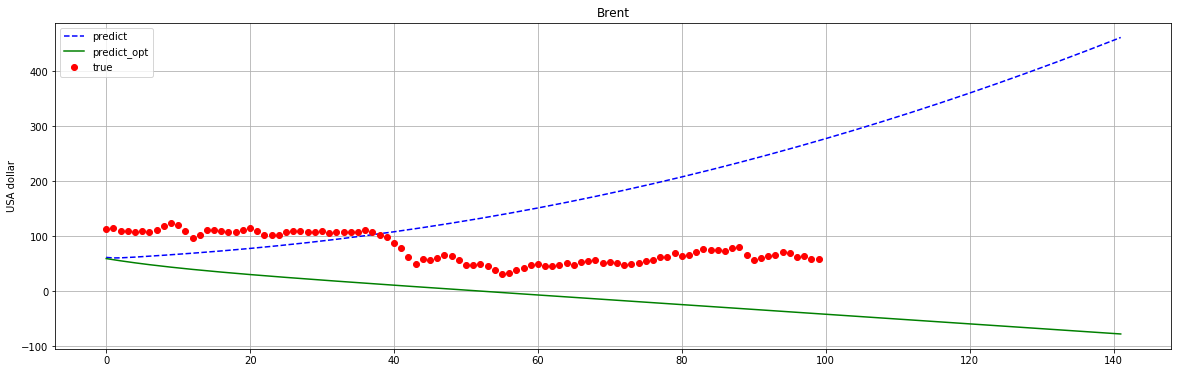

In [22]:
modb_opt = sm.tsa.statespace.SARIMAX(data_brent['Значение'].values[:-10],
                               order=[1,0,1],seasonal_order=[0,0,0,0],trend='ct',
                               enforce_stationarity=False,
                               enforce_invertibility=False)
resultsb_opt = modb_opt.fit()
pred_dynamic = resultsb.forecast(142)    #делаем предсказание на 3 точки от текущего конца ряда
pred_dynamic_opt = resultsb_opt.forecast(142) 

plt.figure(figsize =(20,6))
plt.plot(pred_dynamic,'--b', label='predict')
plt.plot(pred_dynamic_opt,'g', label='predict_opt')
#Отобразим истинный значения 
plt.plot(data_brent['Значение'].values[-100:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 12 точек ряда')

plt.ylabel('USA dollar')
plt.title('Brent')
plt.legend()
plt.grid()
plt.show()

In [23]:
from sklearn.metrics import r2_score 
adf_test = sm.tsa.stattools.adfuller(resultsb_opt.resid)
print(adf_test)

(-17.813616690513232, 3.181837336090334e-30, 0, 98, {'1%': -3.4989097606014496, '5%': -2.891516256916761, '10%': -2.5827604414827157}, 522.6889933543725)


#### 5. Оцените результат моделирования.

ADF тест (adf_test[1] != 0) показывает, что пока остатки не являются стационарным рядом, и модель требует доработки, она не отвечает на вопрос о поведении ряда во времени. Это значит, что необходимо убрать сезонную составляющую, чтобы значения прогноза модели были в диапазоне дисперсии остатков.

#### 6. Сделайте предположение о моделях, которые лучше работают с техниками регрессии на основе ARIMA.

Модель ARIMA может быть использована для разработки моделей AR, MA и ARMA. Метод подходит для одномерных временных рядов с трендом и без сезонных компонентов.